### Overview
This notebooks reads a pre-processed set of **English questions** from Kenyan farmers, selects questions on **maize**;   
tokenizes words, removes stopwords, & lemmatizes verbs; creates bi-and tri-grams and network visualizations


### Input: (files saved to your working directory)
* CSV files of cleaned / lower case /  punctuation removed questions: 'kenya_eng_q_clean.csv' 
* created by *question_preprocess.ipynb* --> *kenya-q_eng.ipynb* notebook code

### Output files (in working directory)
* CSV file of top 500 bigrams: 'ken_eng_bigrams_top500maize.csv'
* CSV file of top 500 trigrams:  'ken_eng_trigrams_top500maize.csv'
* HTML file of interactive network diagram of top 40 bigrams: '40bigram_eng_ken_maize_network.html'                                     
* HTML file of interactive network diagram of top 40 trigrams: '40trigram_eng_ken_maize_network.html'

                                          
### Steps:
1. Select questions topic == 'maize'
2. Tokenize - takes ~ 3-4 min to run
3. Remove stopwords & lemmatise verbs
4. Create english bigrams, trigrams, & quadgrams; save as csv files
5. Plot frequency distribution of top 20 bigrams, trigrams
6. Plot & save interactive networkgraphs of top 40 bigrams and trigrams
7. Save top 500 bi- and tri- grams in CSV files
                                                                                                                                                                       
### Local Variables (partial list):
* q_df       
* ken_q_list
* ken_eng_tokens
* all_bigrams
* all_trigrams
* bigram_freq
* unigram_freq                                          
* trigram_freq
                                                                                                                                                                                       

In [3]:
#import packages:  pandas, numpy,nltk, re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
import string
import re

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.util import bigrams
from nltk.util import trigrams
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

#first - pyvis install in conda prompt: 'conda install conda-forge::pyvis'
from pyvis.network import Network

from collections import Counter

from IPython.display import HTML, display, IFrame


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\liulo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\liulo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\liulo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\liulo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\liulo\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [4]:
#load processed country question file
q_df = pd.read_csv('kenya_eng_q_clean.csv')
q_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384774 entries, 0 to 1384773
Data columns (total 4 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   Unnamed: 0      1384774 non-null  int64 
 1   question_id     1384774 non-null  int64 
 2   question_topic  1083079 non-null  object
 3   question_clean  1384774 non-null  object
dtypes: int64(2), object(2)
memory usage: 42.3+ MB


In [7]:
#select questions with topic = 'maize':

#eng_kenya_df = kenya_df.loc[(kenya_df['question_language'] == 'eng'),['question_id','question_content', 'question_topic']]

eng_kenya_maize_df=q_df.loc[(q_df['question_topic'] == 'maize'),['question_id', 'question_topic', 'question_clean']]
len(eng_kenya_maize_df)
#eng_kenya_df = clean_df.loc[(clean_df['question_topic'] != ''),['question_clean']]
eng_kenya_maize_df.head()


,question_id,question_topic,question_clean
77,3853622,maize,which chemical should i use to control worms ...
86,3854105,maize,which fertilizer is best for planting eg maize
105,3857879,maize,there is any effect if tombaco\nis used to sp...
106,3857970,maize,what can i spray my maize when they are attac...
117,3858674,maize,what can i use to control pestcide which destr...


In [8]:
print("the number of english maize questions: ", len(eng_kenya_maize_df))

the number of english maize questions:  100461


In [9]:
#create list of questions to be tokenized:
ken_q_list=list(eng_kenya_maize_df['question_clean'])
print(ken_q_list[0:5])


[' which chemical should i use to control worms which affects the leaves of maize stalk ', ' which fertilizer is best for planting eg maize', ' there is any effect if tombaco\nis used to spay maize as insecside ', 'what  can i spray my maize when they are attacked by stalkbores', 'what can i use to control pestcide which destroy leaves in maize']


In [10]:
# Define functions to tokenize list of questions:  


stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def normalize_verbs(token_list):
    """Lemmatize verbs only."""
    return [lemmatizer.lemmatize(tok, wordnet.VERB) for tok in token_list]

def tokenize_stopwords_normalize(str_list):
    processed = []

    for text in str_list:
        # 1️⃣ tokenize
        tokens = word_tokenize(text)

        # 2️⃣ remove stopwords
        tokens = [
            t for t in tokens
            if t not in stop_words 
        ]

        # 3️⃣ normalize verbs
        tokens = normalize_verbs(tokens)

        processed.append(tokens)

    return processed

In [11]:
ken_eng_tokens = tokenize_stopwords_normalize(ken_q_list)
print(ken_eng_tokens[0:5])
print("Number of tokens: ", len(ken_eng_tokens))

[['chemical', 'use', 'control', 'worm', 'affect', 'leave', 'maize', 'stalk'], ['fertilizer', 'best', 'plant', 'eg', 'maize'], ['effect', 'tombaco', 'use', 'spay', 'maize', 'insecside'], ['spray', 'maize', 'attack', 'stalkbores'], ['use', 'control', 'pestcide', 'destroy', 'leave', 'maize']]
Number of tokens:  100461


In [12]:
#create list of bigrams:
all_bigrams = []

for question in ken_eng_tokens:
    #create bigrams iterator for each element of tokens: ken_eng_tokens.csv
    bigram_iterator = bigrams(question)
    bigram_list = list(bigram_iterator)

    # Add the bigrams of the current question to the overall list
    all_bigrams.extend(bigram_list)

In [13]:
#create list of trigrams, if # tokens >= 3
all_trigrams = []

for question in ken_eng_tokens:
    if len(question) < 3:
        continue
            #create bigrams iterator for each element of tokens: 
    else:
        all_trigrams.extend(list(trigrams(question)))


In [14]:
print("# of trigrams: ", len(all_trigrams))
print(all_trigrams[0:5])
type(all_trigrams)

# of trigrams:  432176
[('chemical', 'use', 'control'), ('use', 'control', 'worm'), ('control', 'worm', 'affect'), ('worm', 'affect', 'leave'), ('affect', 'leave', 'maize')]


list

In [15]:
print("# of bigrams: ", len(all_bigrams))
print(all_bigrams[0:5])
type(all_bigrams)

# of bigrams:  532553
[('chemical', 'use'), ('use', 'control'), ('control', 'worm'), ('worm', 'affect'), ('affect', 'leave')]


list

In [16]:
bigram_freq = Counter(all_bigrams)
#type(bigram_freq)

In [17]:
trigram_freq = Counter(all_trigrams)
#type(trigram_freq)

In [ ]:
### Bigram Visualizations:  Note - drop "reply, response" and "follow, response"  bigrams (index=11:12)

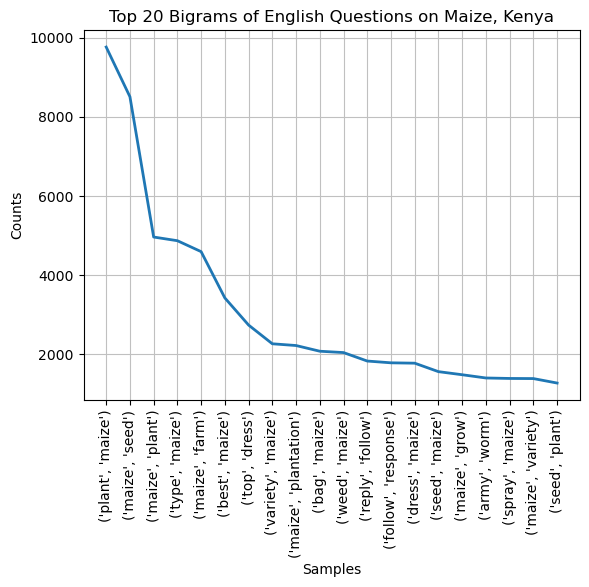

In [18]:
#plot frequency distribution of bigrams
fdist = FreqDist(all_bigrams)
top_n = 20   # change to desired number
fdist.plot(top_n, title=f"Top {top_n} Bigrams of English Questions on Maize, Kenya")
#plt.text(0.5, 1.02, "Source:  WeFarm SMS platform messages among farmers in East Africa, 2022" , fontsize=10, ha='center')
plt.savefig("top20bigrams_maize_ken_eng.png")

In [19]:
#unigram counts for node-size based on token frequency:
 
unigram_freq = Counter(tok for tokens in ken_eng_tokens for tok in tokens)
print(unigram_freq.most_common(75))

[('maize', 102430), ('plant', 22131), ('best', 17089), ('seed', 11679), ('use', 11322), ('farm', 7863), ('type', 7778), ('control', 6129), ('many', 5335), ('good', 5073), ('one', 4376), ('grow', 4251), ('fertilizer', 4234), ('variety', 4169), ('harvest', 4077), ('county', 4054), ('season', 4053), ('weed', 3949), ('ask', 3933), ('get', 3661), ('time', 3572), ('bag', 3566), ('top', 3511), ('well', 3302), ('yellow', 3039), ('dress', 2802), ('acre', 2776), ('take', 2766), ('spray', 2730), ('apply', 2696), ('worm', 2686), ('leave', 2666), ('affect', 2639), ('chemical', 2630), ('cause', 2615), ('plantation', 2487), ('long', 2438), ('bean', 2358), ('suitable', 2333), ('dry', 2331), ('rain', 2328), ('land', 2114), ('reply', 2089), ('follow', 2079), ('want', 2016), ('hybrid', 1993), ('attack', 1942), ('price', 1900), ('soil', 1858), ('crop', 1828), ('response', 1820), ('topdress', 1791), ('store', 1781), ('make', 1759), ('farmer', 1741), ('need', 1730), ('turn', 1722), ('space', 1720), ('diseas

In [24]:
print(bigram_freq.most_common()[:11] + bigram_freq.most_common()[13:42])
len(bigram_freq.most_common()[:11] + bigram_freq.most_common()[13:42])

[(('plant', 'maize'), 9765), (('maize', 'seed'), 8509), (('maize', 'plant'), 4965), (('type', 'maize'), 4872), (('maize', 'farm'), 4596), (('best', 'maize'), 3426), (('top', 'dress'), 2741), (('variety', 'maize'), 2268), (('maize', 'plantation'), 2224), (('bag', 'maize'), 2080), (('weed', 'maize'), 2046), (('dress', 'maize'), 1778), (('seed', 'maize'), 1564), (('maize', 'grow'), 1486), (('army', 'worm'), 1404), (('spray', 'maize'), 1392), (('maize', 'variety'), 1389), (('seed', 'plant'), 1276), (('maize', 'bean'), 1276), (('affect', 'maize'), 1224), (('maize', 'take'), 1218), (('maize', 'best'), 1196), (('many', 'bag'), 1185), (('maize', 'well'), 1175), (('topdress', 'maize'), 1168), (('harvest', 'maize'), 1138), (('hybrid', 'maize'), 1137), (('chemical', 'use'), 1133), (('use', 'maize'), 1080), (('one', 'acre'), 1073), (('use', 'control'), 1045), (('worm', 'maize'), 985), (('maize', 'good'), 960), (('grow', 'maize'), 947), (('turn', 'yellow'), 923), (('attack', 'maize'), 874), (('stor

40

In [30]:
#create interactive directed network chart...with help from Anaconda toolbox

# Variables:
# - bigram_freq: Counter object with bigram frequencies (ranging from ~900 to 10000)
# - unigram_freq: Counter object with country unigram frequencies (up to ~ 100000)

# Get top 40 bigrams, excluding the 11th and 12th:  
top_n = 40
top_bigrams = bigram_freq.most_common()[:11] + bigram_freq.most_common()[13:top_n+2]


# Create a graph
G = nx.DiGraph()

# Add edges (bigrams) with weights based on frequency
for bigram, frequency in top_bigrams:
    word1, word2 = bigram
    G.add_edge(word1, word2, value=frequency, title=f"Frequency: {frequency}")

# Calculate node sizes based on unigram frequencies
max_node_size = 50  # Maximum node size for visualization
min_node_size = 10  # Minimum node size for visualization

# Get all unique words from the bigrams
all_words = set()
for bigram, _ in top_bigrams:
    all_words.add(bigram[0])
    all_words.add(bigram[1])

# Set node sizes based on unigram frequencies
for word in all_words:
    # Get frequency from unigram counter, default to minimum if not found
    frequency = unigram_freq.get(word, 10000)
    
    # Scale node size based on frequency
    # Map from range [5000, 15000] to [min_node_size, max_node_size]
    size = min_node_size + (max_node_size - min_node_size) * (
        (frequency) / (100000)
    ) if frequency >= 10000 else min_node_size
    
    # Set node attributes
    G.nodes[word]['size'] = size
    G.nodes[word]['title'] = f"{word}: {frequency}"
    G.nodes[word]['label'] = word

# Create interactive network
net = Network(notebook=True, height="750px", width="100%", bgcolor="#ffffff", font_color="black")
net.from_nx(G)

# Configure physics for better visualization
net.toggle_physics(True)
net.barnes_hut(gravity=-2000, central_gravity=0.3, spring_length=150)

# Add edge thickness based on bigram frequency

for edge in net.edges:
    # Scale edge width based on weight
   weight = edge['value']
    # Map from range [900, 10000] to [1, 10] for edge width
   edge['width'] = 1 + 9 * ((weight - 900) / (10000 - 900)) if weight >= 900 else 1
   edge['title'] = f"Frequency: {weight}"

    # Improve arrow visibility
   edge['arrows'] = 'to'
   edge['smooth'] = {'type': 'curvedCW', 'roundness': 0.2}  # Curved edges for better visibility
   edge['color'] = {'opacity': 0.5} 
    
# Add some color to distinguish nodes
subdued_colors = [
    '#7D9D9C', '#576F72', '#8B9A46', '#A4BE7B', '#5F7161', 
    '#6D8B74', '#94B49F', '#B4CFB0', '#9CB4CC', '#748DA6',
    '#6096B4', '#93BFCF', '#BDCDD6', '#9F73AB', '#A084DC'
]

for i, node in enumerate(net.nodes):
     node['font'] = {'bold': True, 'size': 16, 'face': 'arial'}
     node['color'] = subdued_colors[i % len(subdued_colors)]
     node['borderWidth'] = 2
     node['borderWidthSelected'] = 4


# Save the HTML file with the title and legend included
filename = "40bigram_eng_ken_maize_network.html"
net.write_html(filename) 
print(f"Visualization saved as '{filename}'")

# Inject title + subtitle inside the iframe display
with open(filename, "r", encoding="utf-8") as f:
    html = f.read()

    header_html = f"""
    <div style="text-align:center; font-family:Arial; padding-top:10px;">
        <h1 style="margin-bottom:2px; font-size:20px;">Network Graph: Top 40 Bigrams from Kenyan Farmer English Questions on Maize</h1>
        <h3 style="margin-top:0; color:#555; font-size:14px;">Word circle size = word frequency, arrow width = bigram frequency, Source: WeFarm 2022 SMS Platform</h3>
        <hr style="width:80%; margin-top:10px; margin-bottom:15px;">
    </div>
    """

# Insert heading right after <body>
html = html.replace("<body>", "<body>" + header_html)

with open(filename, "w", encoding="utf-8") as f:
    f.write(html)

# Display in notebook
display(IFrame(filename, width="100%", height="800px"))


Visualization saved as '40bigram_eng_ken_maize_network.html'


### Trigram Visualizations:  Note - most frequent trigram isn't informative, so should be dropped

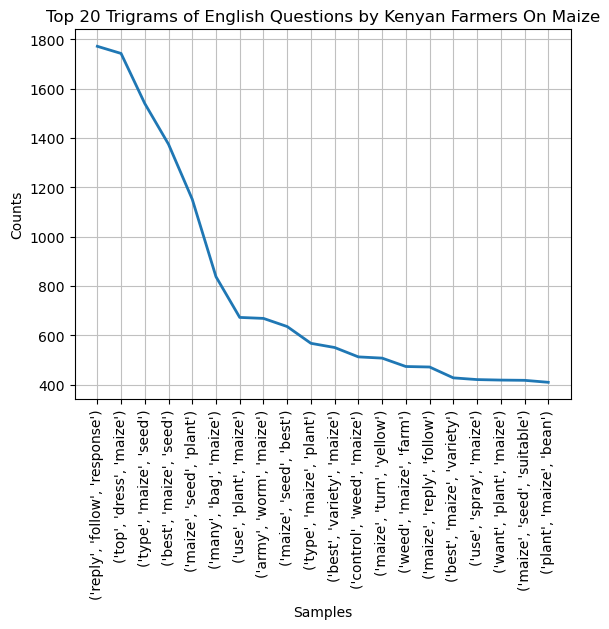

In [31]:
#plot frequency distribution of trigrams
fdist = FreqDist(all_trigrams)
top_n = 20   # change to desired number
fdist.plot(top_n, title=f"Top {top_n} Trigrams of English Questions by Kenyan Farmers On Maize")
plt.savefig("top20trigrams_maize_ken_eng.png")

In [17]:
from IPython.display import IFrame

In [45]:
#interactive directed network graph of top 30 trigrams...with help from Anaconda Assistant

# Input variables:
# - trigram_freq: Counter object with trigram frequencies (ranging from 200 to 1800)
# - unigram_freq: Counter object with unigram frequencies (up to 100000)

#choose most frequent N bigrams, after dropping 1st trigram:
top_n = 40
top_trigrams = trigram_freq.most_common()[1:top_n+1]

# Create a directed graph
G = nx.DiGraph()

# For trigrams, we'll create a path: word1 -> word2 -> word3
for trigram, frequency in top_trigrams:
    word1, word2, word3 = trigram
    
    # Add edges with weights based on frequency
    G.add_edge(word1, word2, value=frequency, title=f"Part of trigram: {' '.join(trigram)}, Frequency: {frequency}")
    G.add_edge(word2, word3, value=frequency, title=f"Part of trigram: {' '.join(trigram)}, Frequency: {frequency}")

# Calculate node sizes based on unigram frequencies
max_node_size = 50  # Maximum node size for visualization
min_node_size = 10  # Minimum node size for visualization

# Get all unique words from the trigrams
all_words = set()
for trigram, _ in top_trigrams:
    all_words.update(trigram)

# Set node sizes based on unigram frequencies
for word in all_words:
    # Get frequency from unigram counter, default to minimum if not found
    frequency = unigram_freq.get(word, 10000)
    
    # Scale node size based on frequency
    # Map from range [5000, 15000] to [min_node_size, max_node_size]
    size = min_node_size + (max_node_size - min_node_size) * (
        (frequency - 10000) / (150000 - 10000)
    ) if frequency >= 10000 else min_node_size

    
    # Set node attributes
    G.nodes[word]['size'] = size
    G.nodes[word]['title'] = f"{word}: {frequency}"
    G.nodes[word]['label'] = word

# Create interactive network with directed edges
net = Network(notebook=True, height="750px", width="100%", bgcolor="#ffffff", font_color="#333333", directed=True)
net.heading = ""

net.from_nx(G)

# Configure physics for better visualization
net.toggle_physics(True)
net.barnes_hut(gravity=-2000, central_gravity=0.3, spring_length=150)

# Subtle color palette
subtle_colors = [
    '#E6E6FA', '#D8BFD8', '#DDA0DD', '#EE82EE', '#DA70D6',
    '#BA55D3', '#9370DB', '#8A2BE2', '#9400D3', '#9932CC',
    '#8B008B', '#800080', '#4B0082', '#6A5ACD', '#483D8B',
    '#7B68EE', '#0000FF', '#0000CD', '#00008B', '#000080'
]

# Add edge thickness based on trigram frequency and make arrows somewhat opaque
for edge in net.edges:
    freq = edge['value']
    # Map from range [200, 1800] to [1, 8] for edge width
    edge['width'] = 1 + 7 * ((freq - 200) / (1800 - 200)) if freq >= 200 else 1
    edge['title'] = f"Frequency: {freq}"
    
    # Somewhat opaque curved arrows
    edge['color'] = {'color': '#848484', 'opacity': 0.5}  # 50% opacity
    edge['arrows'] = {'to': {'enabled': True, 'scaleFactor': 0.6}}
    edge['smooth'] = {'type': 'curvedCW', 'roundness': 0.2}

# Enhance node appearance with bold labels and subtle colors
for i, node in enumerate(net.nodes):
    node['font'] = {'bold': True, 'size': 16, 'face': 'arial'}
    node['color'] = subtle_colors[i % len(subtle_colors)]
    node['borderWidth'] = 2
    node['borderWidthSelected'] = 4

# Save the HTML file with the title and legend included
filename = "40trigram_eng_ken_maize_network.html"
net.write_html(filename) 
print(f"Visualization saved as '{filename}'")

# Inject title + subtitle inside the iframe display
with open(filename, "r", encoding="utf-8") as f:
    html = f.read()

    header_html = f"""
    <div style="text-align:center; font-family:Arial; padding-top:10px;">
        <h1 style="margin-bottom:2px; font-size:20px;">Network Graph: Top 40 Trigrams from Kenyan Farmer English Questions on Maize</h1>
        <h3 style="margin-top:0; color:#555; font-size:14px;">Word circle size = word frequency, arrow width = trigram frequency, Source: WeFarm 2022 SMS Platform</h3>
        <hr style="width:80%; margin-top:10px; margin-bottom:15px;">
    </div>
    """

# Insert heading right after <body>
html = html.replace("<body>", "<body>" + header_html)

with open(filename, "w", encoding="utf-8") as f:
    f.write(html)

#display in notebook:
display(IFrame(filename, width="100%", height="800px"))


Visualization saved as '40trigram_eng_ken_maize_network.html'


### Save top 500 bigrams, trigrams to CSV files; plot top 40 quadgrams -- not that informative

In [32]:
#find top 500 bigrams:
top_500 = bigram_freq.most_common(500)
#convert top_500 list to df, and join bigrams with '_' as separators for later translation, note: there are no duplicates
ken_bigrams_500_df = pd.DataFrame(top_500, columns=['bigram','count'])
ken_bigrams_500_df["bigram_str"] = ken_bigrams_500_df["bigram"].apply(lambda t: "_".join(t))

In [33]:
#convert top_500 list to df, and join bigrams with '_' as separators for later translation, note: there are no duplicates
ken_bigrams_500_df = pd.DataFrame(top_500, columns=['bigram','count'])
ken_bigrams_500_df["bigram_str"] = ken_bigrams_500_df["bigram"].apply(lambda t: "_".join(t))
ken_bigrams_500_df.head()

,bigram,count,bigram_str
0,"(plant, maize)",9765,plant_maize
1,"(maize, seed)",8509,maize_seed
2,"(maize, plant)",4965,maize_plant
3,"(type, maize)",4872,type_maize
4,"(maize, farm)",4596,maize_farm


In [34]:
#save in csv file:
ken_bigrams_500_df.to_csv('ken_eng_bigrams_maize_top500.csv')


In [35]:
#find top 500 trigrams:
top_500 = trigram_freq.most_common(500)
#convert top_500 list to df, and join trigrams with '_' as separators for later translation, note: there are no duplicates
ken_trigrams_500_df = pd.DataFrame(top_500, columns=['trigram','count'])
ken_trigrams_500_df["trigram_str"] = ken_trigrams_500_df["trigram"].apply(lambda t: "_".join(t))
ken_trigrams_500_df.head()

,trigram,count,trigram_str
0,"(reply, follow, response)",1772,reply_follow_response
1,"(top, dress, maize)",1743,top_dress_maize
2,"(type, maize, seed)",1540,type_maize_seed
3,"(best, maize, seed)",1375,best_maize_seed
4,"(maize, seed, plant)",1152,maize_seed_plant


In [36]:
#save in csv file:
ken_trigrams_500_df.to_csv('ken_eng_trigrams_maize_top500.csv')


In [38]:
#create list of quadgrams, after checking # tokens >= 4
#from nltk.util import ngrams

all_quadgrams = []

for question in ken_eng_tokens:
    if len(question) < 4:
        continue
            #create bigrams iterator for each element of tokens: 
    else:
        all_quadgrams.extend(list(ngrams(question,4)))
        


In [39]:
print("# of quadgrams: ", len(all_quadgrams))


# of quadgrams:  334134


In [40]:
quadgram_freq = Counter(all_quadgrams)

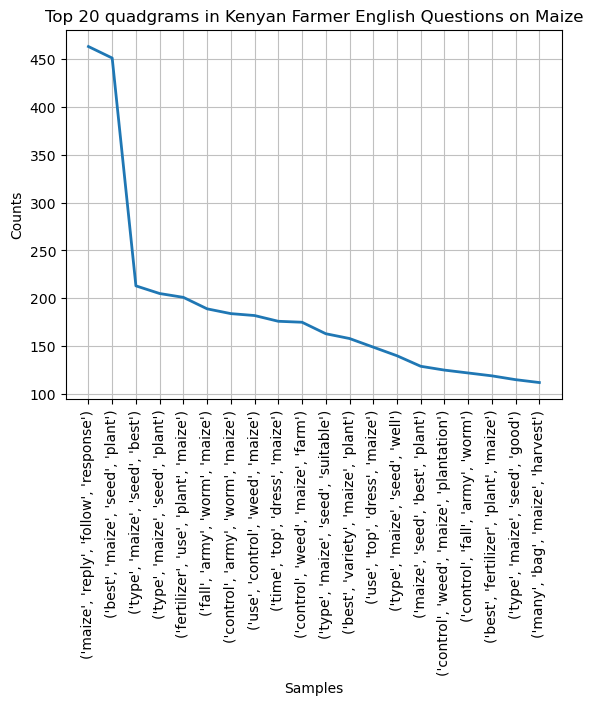

In [42]:
#top 20 quadgram plot

fdist = FreqDist(all_quadgrams)
top_n = 20   # change to desired number
fdist.plot(top_n, title=f"Top {top_n} quadgrams in Kenyan Farmer English Questions on Maize")
plt.savefig("top20quadgrams_ken_maize_eng.png")

In [43]:
#find top 500 quadgrams:
top_500 = quadgram_freq.most_common(500)
#convert top_500 list to df, and join quadgrams with '_' as separators for later translation, note: there are no duplicates
ken_quadgrams_500_df = pd.DataFrame(top_500, columns=['quadgram','count'])
ken_quadgrams_500_df["quadgram_str"] = ken_quadgrams_500_df["quadgram"].apply(lambda t: "_".join(t))

In [44]:
#save in csv file:
ken_quadgrams_500_df.to_csv('ken_eng_quadgrams_maize_top500.csv')